In [2]:
%cd /home/aditya/Documents/SolarCycleProject/code
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import gaussian
import src.preprocesser as pre
import src.network as network
import src.plotter as plotter 
from src.hyperparams import *
%load_ext autoreload

/home/aditya/Documents/SolarCycleProject/code


Using TensorFlow backend.


In [3]:
%autoreload

In [4]:
# Getting the data
headers = ["Year",
           "Month",
           "Day",
           "Decimal Date",
           "Daily Total Sunspot Number",
           "Sunspot Number Stddev",
           "No of observations",
           "Definitive/Provisional"
]
filename = "data/SN_d_tot_V2.0.csv"
data = pd.read_csv(filename, delimiter=";", names=headers)

In [5]:
data

,Year,Month,Day,Decimal Date,Daily Total Sunspot Number,Sunspot Number Stddev,No of observations,Definitive/Provisional
0,1818,1,1,1818.001,-1,-1.0,0,1
1,1818,1,2,1818.004,-1,-1.0,0,1
2,1818,1,3,1818.007,-1,-1.0,0,1
3,1818,1,4,1818.010,-1,-1.0,0,1
4,1818,1,5,1818.012,-1,-1.0,0,1
...,...,...,...,...,...,...,...,...
73743,2019,11,26,2019.903,0,0.0,17,0
73744,2019,11,27,2019.905,0,0.0,12,0
73745,2019,11,28,2019.908,0,0.0,11,0
73746,2019,11,29,2019.911,0,0.0,26,0


In [6]:
# Data Preprocessing
dates, spots, inverter = pre.preprocess(data)

# Reverse the data
dates = dates[::-1]
spots = spots[::-1]

ymax: 528.0 ymin: 0.0
x.shape: (73741,)
y.shape: (73741,)
y values scaler: 264.0


In [7]:
if mean_type == "gaussian":
    weights = gaussian(M=mean_length, std=0.1, sym=True)
    weights /= np.sum(weights) # normalise the weights
    spots = pre.running_mean_helper(spots, weights)
elif mean_type == "uniform":
    weights = np.ones(mean_length)/mean_length
    spots = pre.running_mean_helper(spots, weights)
else:
    pass


In [8]:
X = spots
index = dates
x_slid, y_slid, idx_slid = pre.sliding_window_main(X, X, index)
x_train, y_train, idx_train, x_val, y_val, idx_val, x_test, y_test, idx_test = pre.data_splitting_main(x_slid, y_slid, idx_slid)

x_slid.shape: (73739, 2, 1)
y_slid.shape: (73739, 1)
x_train.shape:  (44240, 2, 1)
y_train.shape:  (44240, 1)
idx_train.shape:  (44240,)
x_val.shape:  (14736, 2, 1)
y_val.shape:  (14736, 1)
idx_val.shape:  (14736,)
x_test.shape:  (14752, 2, 1)
y_test.shape:  (14752, 1)
idx_test.shape:  (14752,)



In [9]:
net = network.create_network()

In [10]:
history = network.trainer(net, x_train, y_train, x_val, y_val, verbose=1)
var_train = np.var(y_train)
var_val = np.var(y_val)
print("Variance in y_train:", var_train)
print("Variance in y_val:", var_val)

Train on 44240 samples, validate on 14736 samples
Epoch 1/100
44240/44240 [==============================] - 11s 255us/step - loss: 0.0050 - val_loss: 0.0116
Epoch 2/100
44240/44240 [==============================] - 9s 194us/step - loss: 0.0049 - val_loss: 0.0118
Epoch 3/100
44240/44240 [==============================] - 9s 212us/step - loss: 0.0048 - val_loss: 0.0118
Epoch 4/100
44240/44240 [==============================] - 9s 202us/step - loss: 0.0048 - val_loss: 0.0118
Epoch 5/100
44240/44240 [==============================] - 9s 205us/step - loss: 0.0048 - val_loss: 0.0118
Epoch 6/100
44240/44240 [==============================] - 9s 205us/step - loss: 0.0048 - val_loss: 0.0118
Epoch 7/100
44240/44240 [==============================] - 9s 206us/step - loss: 0.0048 - val_loss: 0.0118
Epoch 8/100
44240/44240 [==============================] - 9s 210us/step - loss: 0.0048 - val_loss: 0.0118
Epoch 9/100
44240/44240 [==============================] - 9s 213us/step - loss: 0.0048 - val

pred1.shape: (14736, 1)
pred2.shape: (44240, 1)


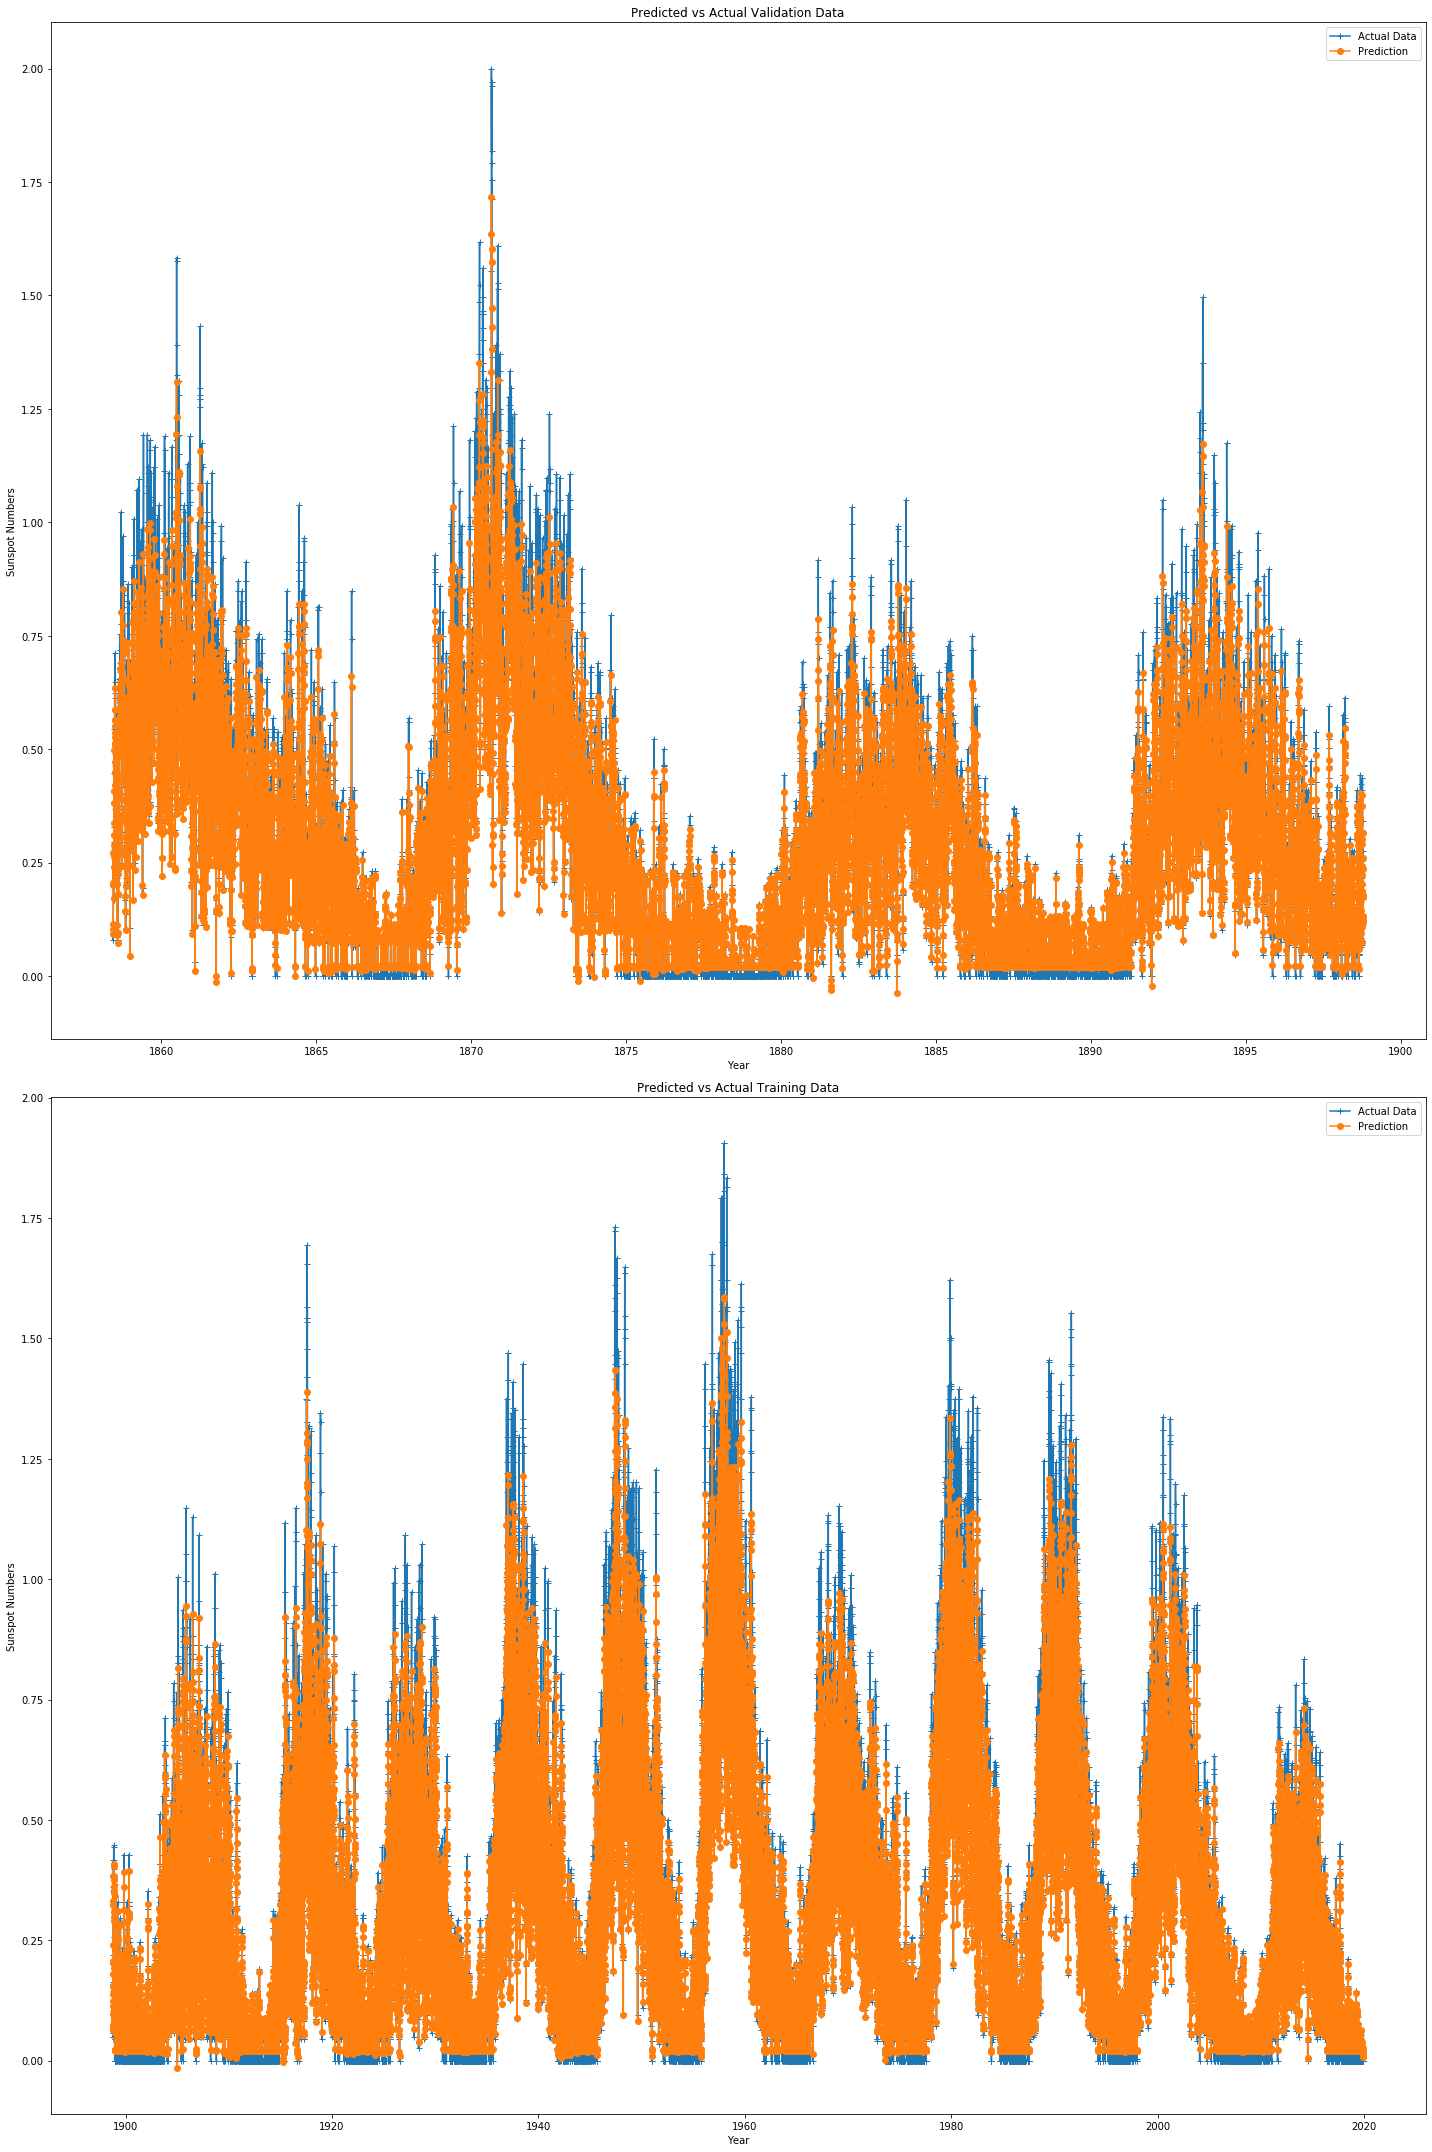

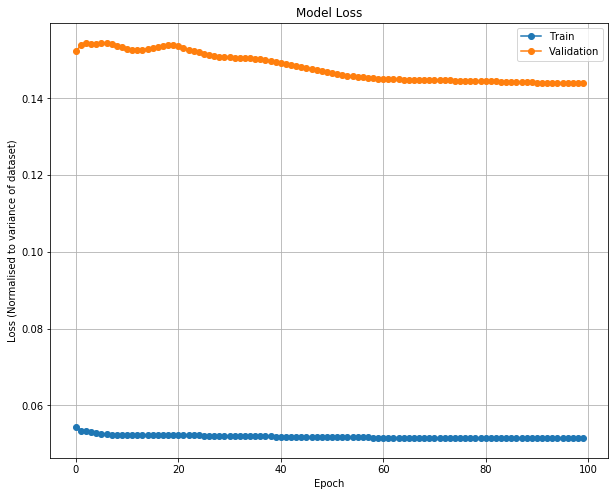

In [11]:
plotter.plot_predictions(net, x_train, y_train, idx_train, x_val, y_val, idx_val)
plotter.plot_loss_vs_epoch(history, var_train, var_val)

In [12]:
predictor = network.create_network(predictor=True)
predictor.set_weights(net.get_weights())

idx_step = np.average(np.diff(idx_slid))
x_start = x_train[:batch_size, :, :]
idx_start = idx_train[:batch_size]
idx_end = 1819.0
args = (
    predictor,
    x_start,
    idx_start,
    idx_end,
    idx_step
)
predictor.reset_states()
# net.reset_states()
npred = predictor.predict(x_train, batch_size=1)
rpred, idx_rpred = network.predict_from_self(*args)

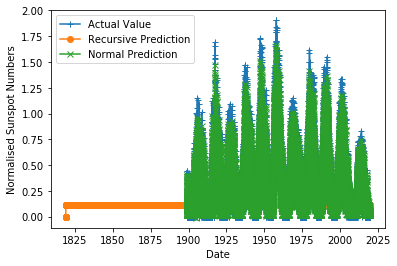

In [13]:
# plt.figure(figsize=(10,8))
plt.plot(idx_train, y_train, label="Actual Value", marker="+")
plt.plot(idx_rpred, rpred, label="Recursive Prediction", marker="o")
plt.plot(idx_train, npred, label="Normal Prediction", marker="x")

plt.xlabel("Date")
plt.ylabel("Normalised Sunspot Numbers")
plt.legend()